In [108]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import sys
# from scipy.optimize import minimize, NonlinearConstraint
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from FNFTpy import nsev

from ssfm import fiber_propogate, get_soliton_pulse, get_gauss_pulse
import waveform_optimiser as wf
import signal_generation as sg
from importlib import reload
reload(wf)
reload(sg)

<module 'signal_generation' from '/home/esf0/PycharmProjects/nn_training/signal_generation.py'>

In [2]:
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.size': 40})


# tex style to regular
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

# regular to tex style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
df = pd.DataFrame()

beta2 = -1.0
gamma = 1.0
nz_span = 2 ** 12

nt_span = 2 ** 8
t_span = 32.0

dt = t_span / nt_span
t = np.array([(i - nt_span / 2) * dt for i in range(nt_span)])
w = np.array([(i - nt_span / 2) * (2. * np.pi / nt_span) for i in range(nt_span)])

In [ ]:
# We have 6 * 4 * 20 signals
# for each energy and band_limit we have 20 optimised inputs
# each input propagate over 20 (25) l_d

# for energy_sys in [3.0, 6.0, 9., 12., 15., 18.]:
#     for band_limit in [0.5, 0.4, 0.3, 0.2]:
#         for z_prop in [1.0 * i for i in range(1, 21)]:
#             path = r'../wf_opt_results/run_1/wf_opt_result_' + str(energy_sys) + '_' + str(band_limit) + '_' + str(z_prop) + '.pkl'
#             data = pd.read_pickle(path)

for energy_sys in [3.0, 6.0, 9., 12., 15., 18.]:
    for band_limit in [0.5, 0.4, 0.3, 0.2]:
        print(energy_sys, band_limit)
        for z_prop_opt in tqdm([1.0 * i for i in range(1, 21)]):
            for z_prop in [1.0 * i for i in range(1, 21)]:
            # for z_prop in [z_prop_opt]:
# for energy_sys in [3.0]:
    # for band_limit in [0.5]:
    #     for z_prop_opt in [1.0 * i for i in range(1, 21)]:
    #         for z_prop in [1.0]:
                path = r'../wf_opt_results/run_1/wf_opt_result_' + str(energy_sys) + '_' + str(band_limit) + '_' + str(z_prop_opt) + '.pkl'
                data = pd.read_pickle(path)
                # print(data)
                if not data['success']:
                    # print('Warning: optimisation failed')
                    # print(energy_sys, band_limit, z_prop_opt)
                    continue

                w_init = wf.decompose(data['x'])
                # e_lost = wf.get_e_lost(w_init, band_limit, t_span, nt_span, z_prop, nz_span, gamma, beta2)
                # print(e_lost)

                w_init, x_c, spectrum, signal_end = wf.get_signal_from_cut(w_init, band_limit, t_span, nt_span,
                                                                           z_prop, nz_span, gamma, beta2, key=0)
                e_lost, e_rest = wf.get_outband_energy(spectrum, t_span, w, band_limit)
                e_tot = wf.get_energy(x_c, t_span)
                e_tot_end = wf.get_energy(signal_end, t_span)
                # print(e_lost, e_rest)
                # print(wf.get_energy(x_c, t_span), wf.get_energy(signal_end, t_span))

                result_dict = {'type': 'optimised',
                               'energy': energy_sys,
                               'band_limit': band_limit,
                               'z_prop_opt': z_prop_opt,
                               'z_prop': z_prop,
                               'nz_span': nz_span,
                               'beta2': beta2,
                               'gamma': gamma,
                               't_span': t_span,
                               'nt_span': nt_span,
                               'w_init': w_init,
                               'w_end': spectrum,
                               'signal_init': x_c,
                               'signal_end': signal_end,
                               'e_lost': e_lost,
                               'e_rest': e_rest,
                               'e_tot_init': e_tot,
                               'e_tot_end': e_tot_end,
                               'data': data
                               }
                df = df.append(result_dict, ignore_index=True)

df.to_pickle(r'../wf_opt_results/run_1.pkl')

In [9]:
for type in ['soliton_sinc', 'gauss']:
    for energy_sys in [3.0, 6.0, 9., 12., 15., 18.]:
        for band_limit in [0.5, 0.4, 0.3, 0.2]:
            for z_prop in tqdm([1.0 * i for i in range(1, 21)]):
                if type == 'soliton_sinc':
                    signal_init = sg.set_energy(wf.get_soliton_sinc(t, w, band_limit, beta2, gamma), energy_sys, dt)
                elif type == 'gauss':
                    signal_init = sg.set_energy(get_gauss_pulse(1.0, t, tau=1), energy_sys, dt)
                else:
                    print('Unknown type')
                    break

                spec_init = wf.get_spec_limited(fftshift(fft(signal_init)), w, band_limit)

                w_init, x_c, spectrum, signal_end = wf.get_signal_from_cut(spec_init, band_limit, t_span, nt_span,
                                                                               z_prop, nz_span, gamma, beta2, key=0)
                e_lost, e_rest = wf.get_outband_energy(spectrum, t_span, w, band_limit)
                e_tot = wf.get_energy(x_c, t_span)
                e_tot_end = wf.get_energy(signal_end, t_span)
                # print(e_lost, e_rest)
                # print(wf.get_energy(x_c, t_span), wf.get_energy(signal_end, t_span))

                result_dict = {'type': type,
                               'energy': energy_sys,
                               'band_limit': band_limit,
                               'z_prop_opt': 0,
                               'z_prop': z_prop,
                               'nz_span': nz_span,
                               'beta2': beta2,
                               'gamma': gamma,
                               't_span': t_span,
                               'nt_span': nt_span,
                               'w_init': w_init,
                               'w_end': spectrum,
                               'signal_init': x_c,
                               'signal_end': signal_end,
                               'e_lost': e_lost,
                               'e_rest': e_rest,
                               'e_tot_init': e_tot,
                               'e_tot_end': e_tot_end,
                               'data': None
                               }

                df = df.append(result_dict, ignore_index=True)

df.to_pickle(r'../wf_opt_results/run_1_sol.pkl')

In [4]:
df_opt = pd.read_pickle(r'../wf_opt_results/run_1.pkl')
df_ref = pd.read_pickle(r'../wf_opt_results/run_1_sol.pkl')

df_all = pd.concat([df_opt, df_ref])

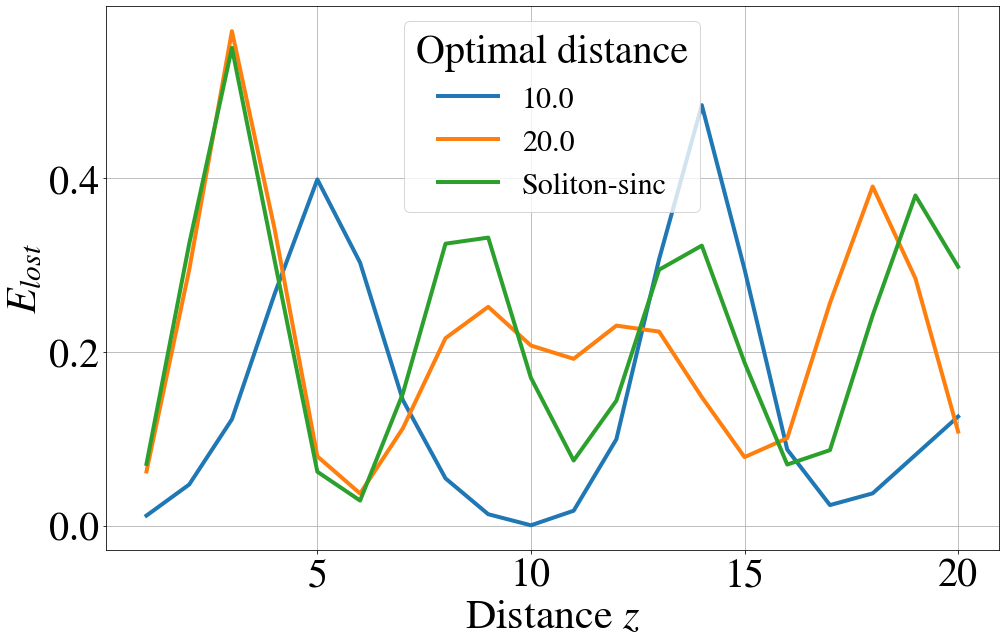

In [95]:
cur_band_limit = 0.2
cur_energy = 3.0
df_p1_opt = df_all[(df_all.type == 'optimised') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
df_p1_ref = df_all[(df_all.type == 'soliton_sinc') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
# print(df_p1_opt[(df_p1_opt.z_prop_opt == 3)].e_lost.to_numpy())



fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

# for z_prop in [1.0 * i for i in range(1, 21)]:
for z_prop in [10.0, 20.0]:
    df_p1_temp = df_p1_opt[(df_p1_opt.z_prop_opt == z_prop)]

    ax.plot(df_p1_temp.z_prop, df_p1_temp.e_lost / cur_energy,
            label=str(z_prop),
            linewidth=4.0)

ax.plot(df_p1_ref.z_prop, df_p1_ref.e_lost / cur_energy,
            label='Soliton-sinc',
            linewidth=4.0)

# ax.set_yscale('log')
# ax.set_title('')
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.2, 17)
ax.set_ylabel(r'$E_{lost}$', fontsize=42)
ax.set_xlabel(r'Distance $z$', fontsize=42)
ax.grid()

plt.legend(title='Optimal distance', loc='best', fontsize=30)
# plt.tight_layout()
plt.show()
fig.savefig(r'../wf_opt_results/' + 'bl_' + str(cur_band_limit) + '_e_' + str(cur_energy) + '.pdf', format='pdf', bbox_inches='tight')

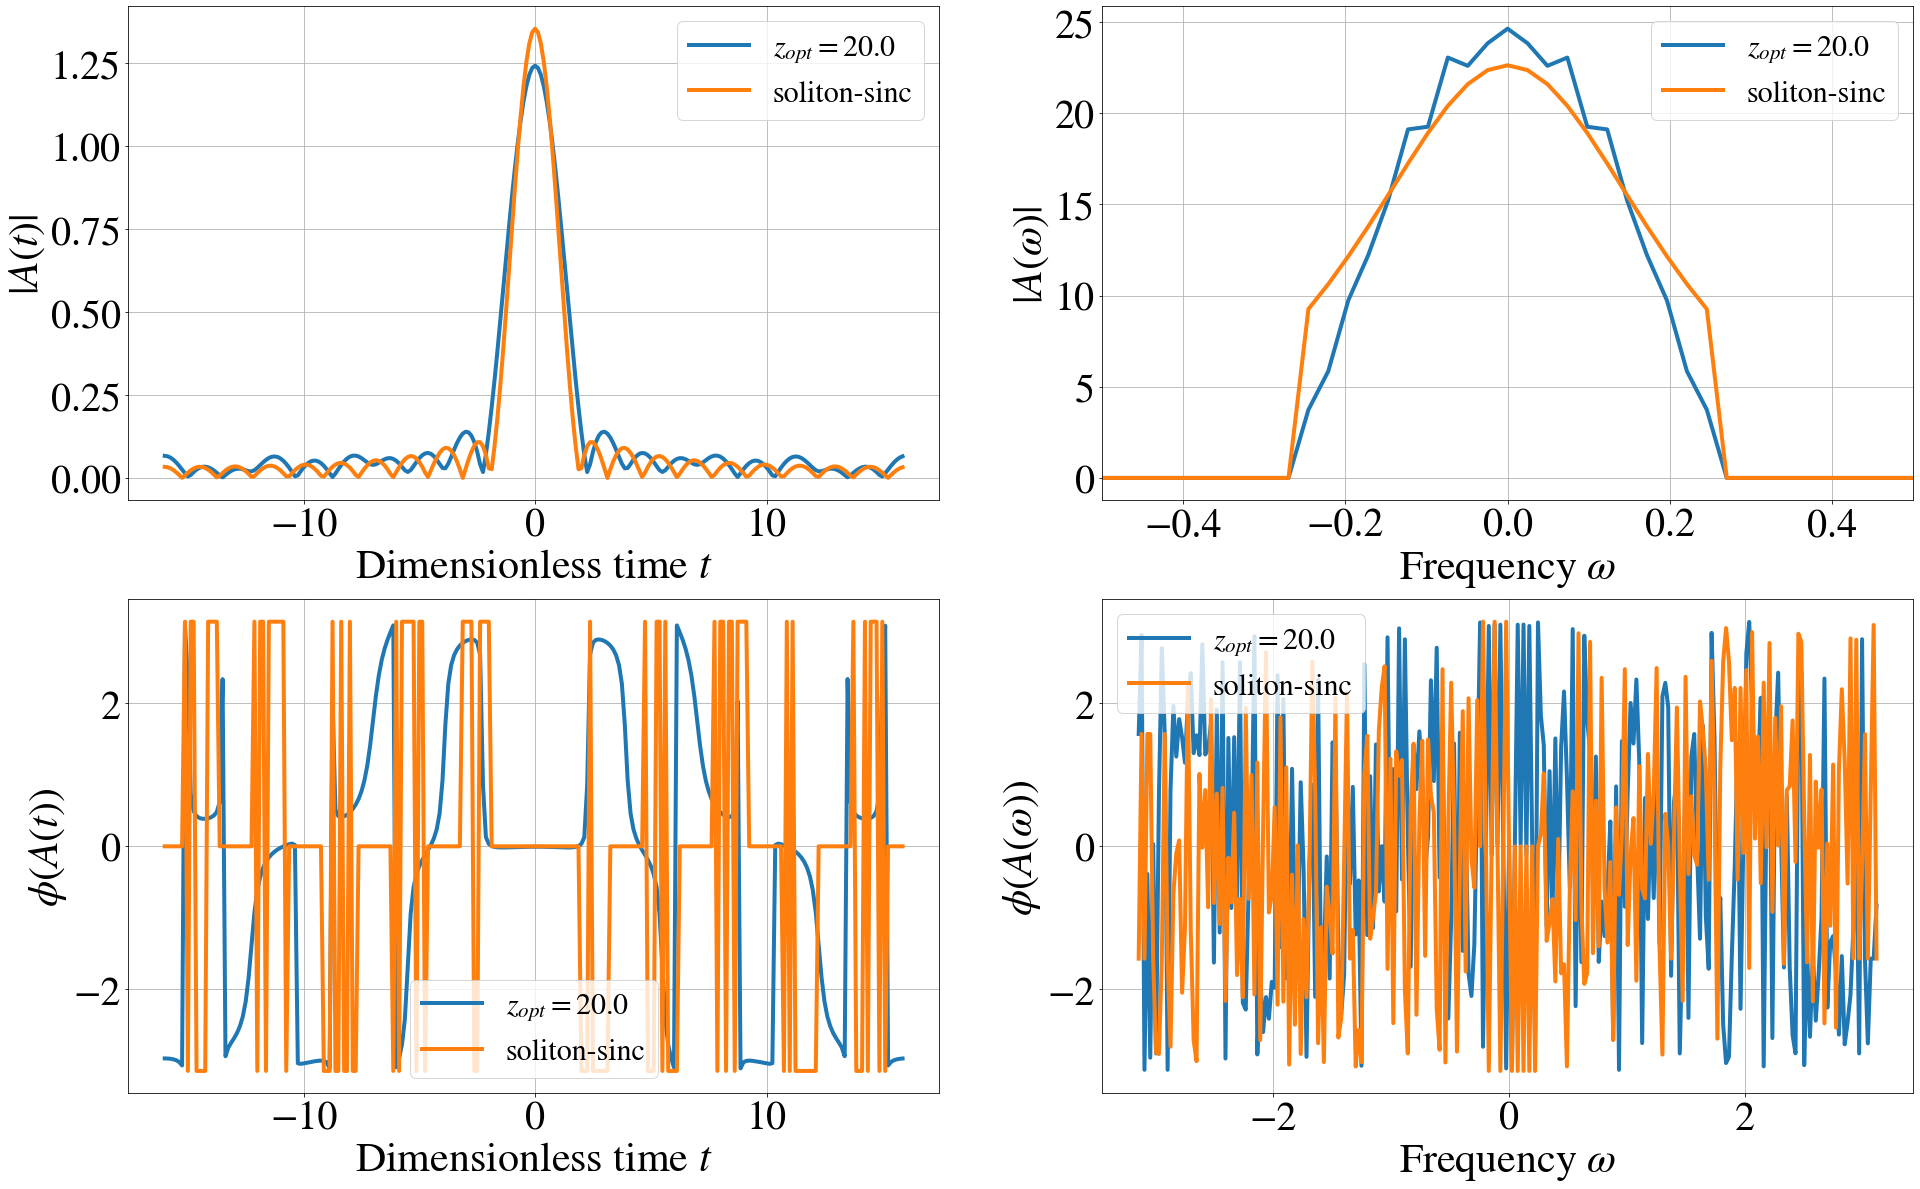

In [85]:
cur_band_limit = 0.5
cur_energy = 3.0
z_prop = 20.0

df_p1_opt = df_all[(df_all.type == 'optimised') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
df_p1_ref = df_all[(df_all.type == 'soliton_sinc') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
# print(df_p1_opt[(df_p1_opt.z_prop_opt == 3)].e_lost.to_numpy())



fig = plt.figure(figsize=(32,20))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


df_p1_temp = df_p1_opt[(df_p1_opt.z_prop_opt == z_prop) & (df_p1_opt.z_prop == z_prop)]
df_ref_temp = df_p1_ref[(df_p1_ref.z_prop_opt == 0.) & (df_p1_ref.z_prop == z_prop)]
# print(df_p1_temp.signal_init.item())
ax.plot(t, np.absolute(df_p1_temp.signal_init.item()),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax.plot(t, np.absolute(df_ref_temp.signal_init.item()),
            label=r'soliton-sinc',
            linewidth=4.0)

ax3.plot(t, np.angle(df_p1_temp.signal_init.item()),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax3.plot(t, np.angle(df_ref_temp.signal_init.item()),
            label=r'soliton-sinc',
            linewidth=4.0)

ax2.plot(w, np.absolute(fftshift(fft(df_p1_temp.signal_init.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax2.plot(w, np.absolute(fftshift(fft(df_ref_temp.signal_init.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)

ax4.plot(w, np.angle(fftshift(fft(df_p1_temp.signal_init.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax4.plot(w, np.angle(fftshift(fft(df_ref_temp.signal_init.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)


ax.set_ylabel(r'$|A(t)|"$', fontsize=42)
ax.set_xlabel(r'Dimensionless time $t$', fontsize=42)
ax.grid()

ax3.set_ylabel(r'$\phi(A(t))"$', fontsize=42)
ax3.set_xlabel(r'Dimensionless time $t$', fontsize=42)
ax3.grid()

ax2.set_ylabel(r'$|A(\omega)|"$', fontsize=42)
ax2.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax2.grid()

ax4.set_ylabel(r'$\phi(A(\omega))"$', fontsize=42)
ax4.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax4.grid()


ax2.set_xlim(-0.5, 0.5)

ax.legend(loc='best', fontsize=30)
ax2.legend(loc='best', fontsize=30)
ax3.legend(loc='best', fontsize=30)
ax4.legend(loc='best', fontsize=30)

# plt.legend(title='Optimal distance', loc='best', fontsize=30)
# plt.tight_layout()
plt.show()
fig.savefig(r'../wf_opt_results/' + 'signal_opt_bl_' + str(cur_band_limit) + '_e_' + str(cur_energy) + '_z_' + str(z_prop) + '.pdf', format='pdf', bbox_inches='tight')


In [117]:
cur_band_limit = 0.2
cur_energy = 3.0
z_prop = 20.0

nt_span = 2 ** 8
t_span = 32.0
dt = t_span / nt_span
t = np.array([(i - nt_span / 2) * dt for i in range(nt_span)])

df_p1_opt = df_all[(df_all.type == 'optimised') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
df_p1_ref = df_all[(df_all.type == 'soliton_sinc') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]

df_p1_temp = df_p1_opt[(df_p1_opt.z_prop_opt == z_prop) & (df_p1_opt.z_prop == z_prop)]
df_ref_temp = df_p1_ref[(df_p1_ref.z_prop_opt == 0.) & (df_p1_ref.z_prop == z_prop)]

signal = df_p1_temp.signal_init.item()
n_signal = len(signal)
xi_span = np.pi / (2. * dt) * 2
dxi = xi_span / n_signal
xi = np.linspace(-xi_span / 2. + dxi, xi_span / 2., n_signal * 2)

res = nsev(signal, t, M=n_signal, Xi1=xi[0], Xi2=xi[-1], K=512)

print(res)
p_ave_nd = sg.get_average_power(signal, dt)
p_ave_db = sg.mw_to_dbm(sg.nd_to_mw(p_ave_nd, t_symb=14.6))
print(p_ave_db)

{'return_value': 0, 'bound_states_num': 3, 'bound_states': array([-3.90372926e-01+0.00581084j,  3.89882885e-01+0.00610877j,
       -3.44997698e-06+0.64935009j]), 'disc_norm': array([ 1.01641918+0.06052073j,  0.97809825+0.05733892j,
       -0.99933662-0.00189105j]), 'cont_ref': array([ 2.73396829e-04-1.01838880e-03j, -2.88960137e-04+1.02999975e-03j,
        3.04904488e-04-1.04171112e-03j, -3.21240316e-04+1.05352676e-03j,
        3.37978529e-04-1.06545070e-03j, -3.55130532e-04+1.07748714e-03j,
        3.72708252e-04-1.08964042e-03j, -3.90724162e-04+1.10191510e-03j,
        4.09191305e-04-1.11431590e-03j, -4.28123330e-04+1.12684774e-03j,
        4.47534512e-04-1.13951577e-03j, -4.67439792e-04+1.15232534e-03j,
        4.87854807e-04-1.16528200e-03j, -5.08795924e-04+1.17839159e-03j,
        5.30280280e-04-1.19166015e-03j, -5.52325820e-04+1.20509402e-03j,
        5.74951342e-04-1.21869979e-03j, -5.98176539e-04+1.23248435e-03j,
        6.22022045e-04-1.24645489e-03j, -6.46509491e-04+1.2606189

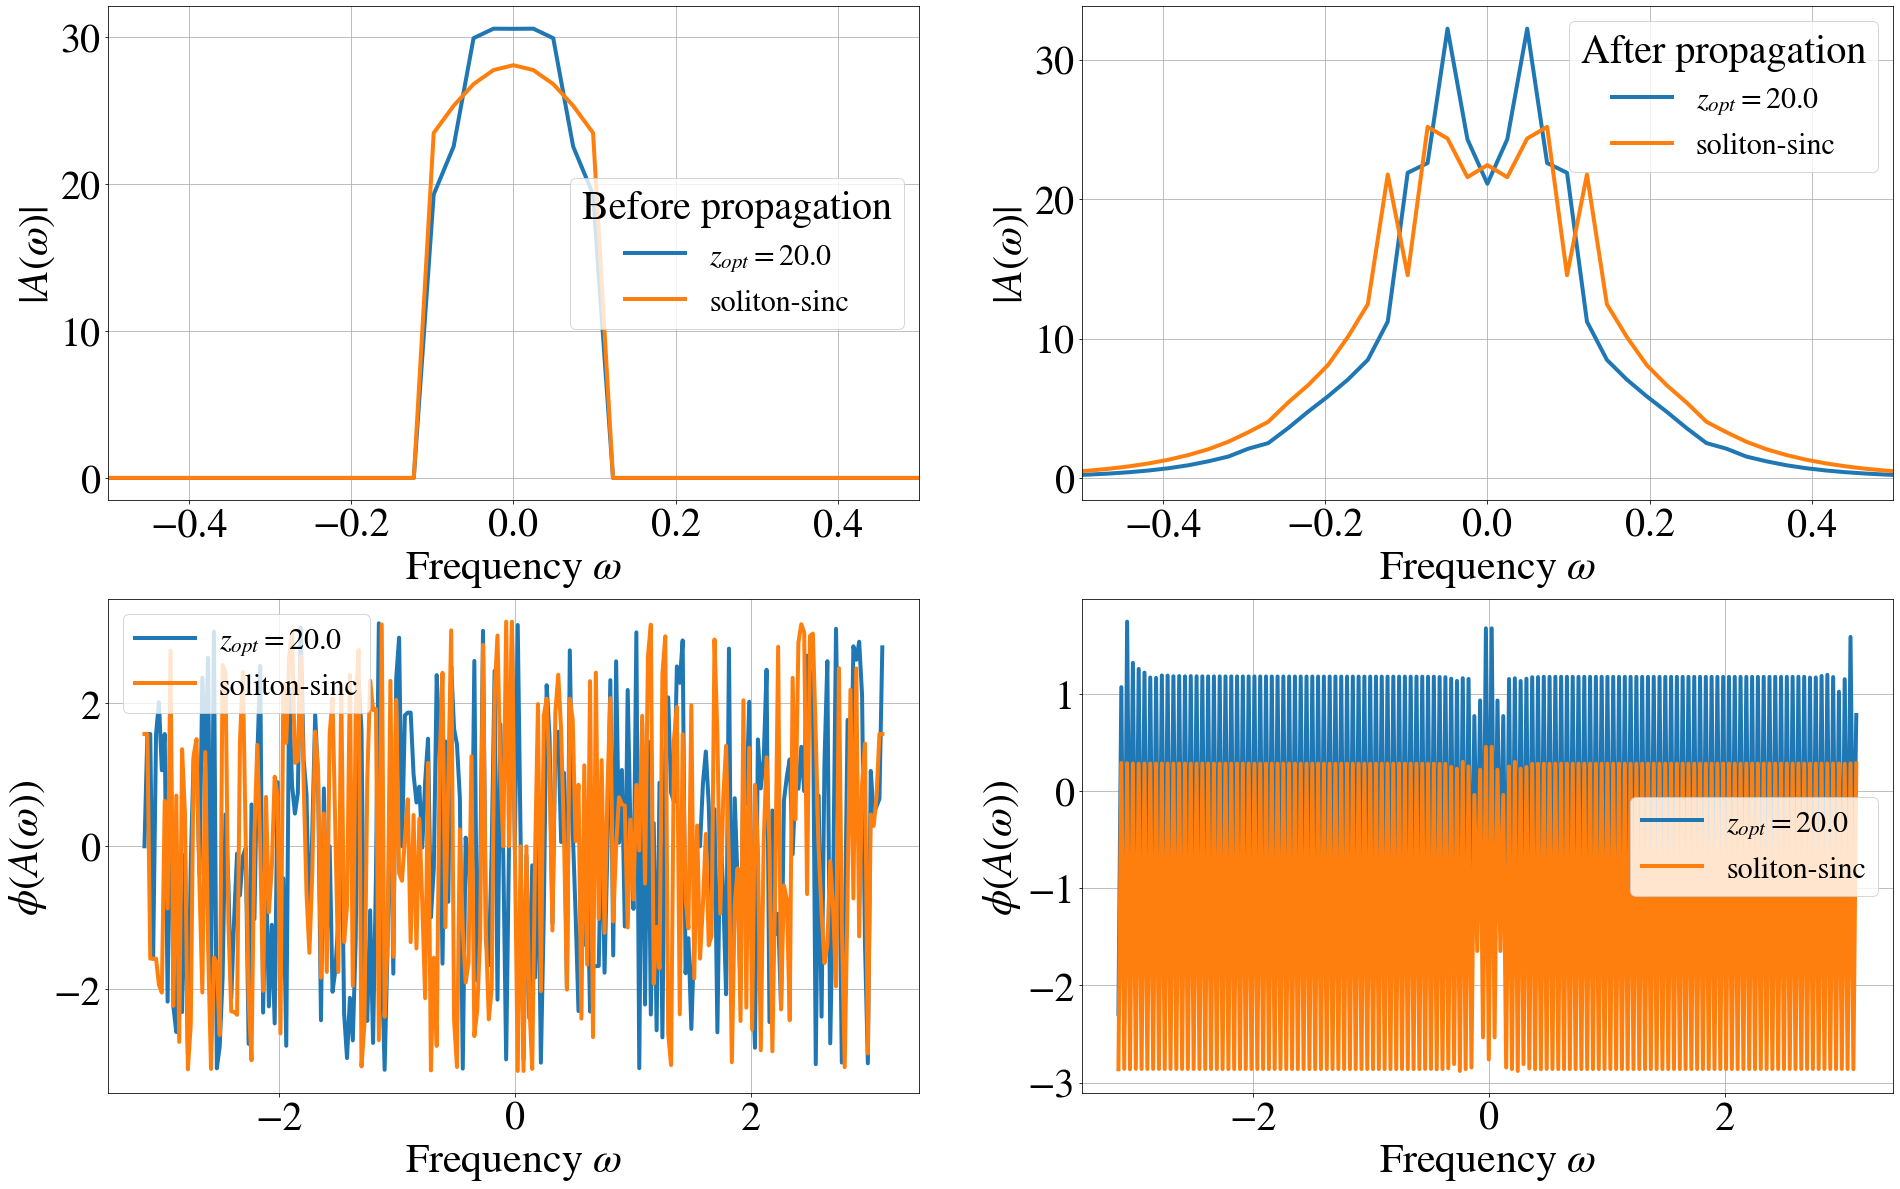

In [106]:
cur_band_limit = 0.2
cur_energy = 3.0
z_prop = 20.0

df_p1_opt = df_all[(df_all.type == 'optimised') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
df_p1_ref = df_all[(df_all.type == 'soliton_sinc') & (df_all.band_limit == cur_band_limit) & (df_all.energy == cur_energy)]
# print(df_p1_opt[(df_p1_opt.z_prop_opt == 3)].e_lost.to_numpy())



fig = plt.figure(figsize=(32,20))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


df_p1_temp = df_p1_opt[(df_p1_opt.z_prop_opt == z_prop) & (df_p1_opt.z_prop == z_prop)]
df_ref_temp = df_p1_ref[(df_p1_ref.z_prop_opt == 0.) & (df_p1_ref.z_prop == z_prop)]
# print(df_p1_temp.signal_init.item())
ax.plot(w, np.absolute(fftshift(fft(df_p1_temp.signal_init.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax.plot(w, np.absolute(fftshift(fft(df_ref_temp.signal_init.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)

ax3.plot(w, np.angle(fftshift(fft(df_p1_temp.signal_init.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax3.plot(w, np.angle(fftshift(fft(df_ref_temp.signal_init.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)

ax2.plot(w, np.absolute(fftshift(fft(df_p1_temp.signal_end.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax2.plot(w, np.absolute(fftshift(fft(df_ref_temp.signal_end.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)

ax4.plot(w, np.angle(fftshift(fft(df_p1_temp.signal_end.item()))),
            label=r'$z_{opt} = $' + str(z_prop),
            linewidth=4.0)
ax4.plot(w, np.angle(fftshift(fft(df_ref_temp.signal_end.item()))),
            label=r'soliton-sinc',
            linewidth=4.0)


ax.set_ylabel(r'$|A(\omega)|"$', fontsize=42)
ax.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax.grid()

ax3.set_ylabel(r'$\phi(A(\omega))"$', fontsize=42)
ax3.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax3.grid()

ax2.set_ylabel(r'$|A(\omega)|"$', fontsize=42)
ax2.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax2.grid()

ax4.set_ylabel(r'$\phi(A(\omega))"$', fontsize=42)
ax4.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax4.grid()


ax.set_xlim(-0.5, 0.5)
ax2.set_xlim(-0.5, 0.5)

ax.legend(title='Before propagation', loc='best', fontsize=30)
ax2.legend(title='After propagation',loc='best', fontsize=30)
ax3.legend(loc='best', fontsize=30)
ax4.legend(loc='best', fontsize=30)

# plt.legend(title='Optimal distance', loc='best', fontsize=30)
# plt.tight_layout()
plt.show()
fig.savefig(r'../wf_opt_results/' + 'spectrum_opt_bl_' + str(cur_band_limit) + '_e_' + str(cur_energy) + '_z_' + str(z_prop) + '.pdf', format='pdf', bbox_inches='tight')

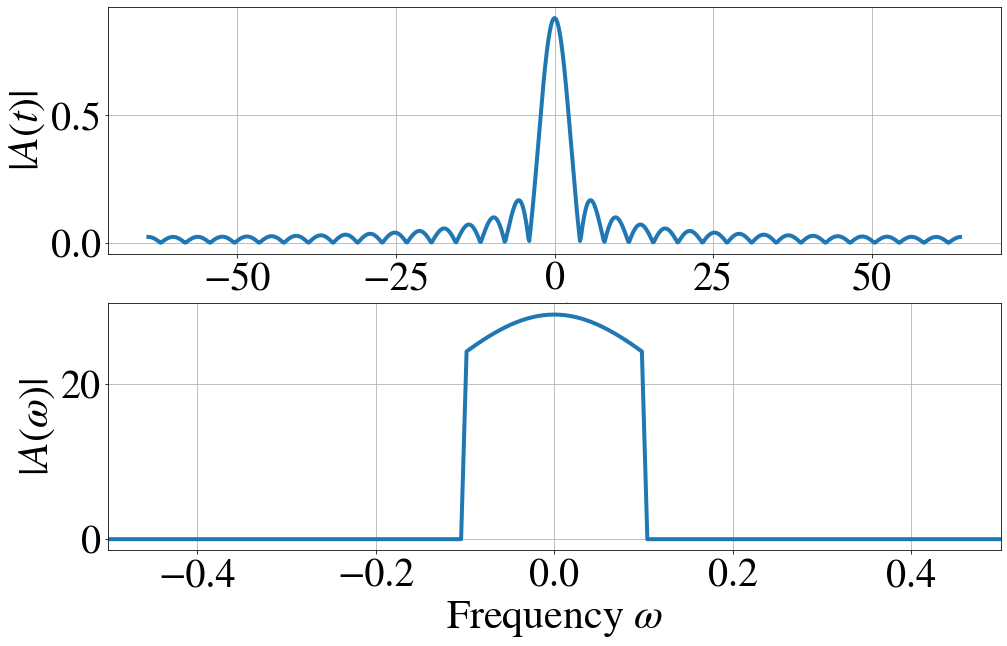

In [42]:
# Print soliton-sinc
band_limit_ss = 0.2
energy_ss = 3.0

beta2 = -1.0
gamma = 1.0
nz_span = 2 ** 12

nt_span_ss = 2 ** 10
t_span_ss = 128.0

dt_ss = t_span_ss / nt_span_ss
t_ss = np.array([(i - nt_span_ss / 2) * dt_ss for i in range(nt_span_ss)])
w_ss = np.array([(i - nt_span_ss / 2) * (2. * np.pi / nt_span_ss) for i in range(nt_span_ss)])

soliton_sinc = sg.set_energy(wf.get_soliton_sinc(t_ss, w_ss, band_limit_ss, beta2, gamma), energy_ss, dt_ss)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(t_ss, np.absolute(soliton_sinc),
            label='Soliton-sinc',
            linewidth=4.0)
ax2.plot(w_ss, np.absolute(fftshift(fft(soliton_sinc))),
            label='Spectrum of soliton-sinc',
            linewidth=4.0)

ax1.set_ylabel(r'$|A(t)|$', fontsize=42)
ax1.set_xlabel(r'Dimensionless time $t$', fontsize=42)
ax1.grid()

ax2.set_ylabel(r'$|A(\omega)|$', fontsize=42)
ax2.set_xlabel(r'Frequency $\omega$', fontsize=42)
ax2.grid()

ax2.set_xlim(-0.5, 0.5)

plt.show()

In [46]:
print(df_p1_ref[df_p1_ref.z_prop == 1.0].signal_end.item())

[ 6.17890238e-02-6.50136027e-02j  6.09857670e-02-6.42020320e-02j
  5.85964426e-02-6.17869343e-02j  5.46816442e-02-5.78266278e-02j
  4.93408545e-02-5.24169553e-02j  4.27097404e-02-4.56890666e-02j
  3.49570215e-02-3.78065728e-02j  2.62800249e-02-2.89617138e-02j
  1.68999960e-02-1.93709853e-02j  7.05632075e-03-9.26991062e-03j
 -2.99922396e-03+1.09253862e-03j -1.30090085e-02+1.14601311e-02j
 -2.27157361e-02+2.15756131e-02j -3.18690901e-02+3.11872085e-02j
 -4.02317082e-02+4.00547928e-02j -4.75853241e-02+4.79559532e-02j
 -5.37359632e-02+5.46913614e-02j -5.85190747e-02+6.00897202e-02j
 -6.18035053e-02+6.40117658e-02j -6.34952293e-02+6.63536613e-02j
 -6.35397480e-02+6.70493308e-02j -6.19240934e-02+6.60721350e-02j
 -5.86773512e-02+6.34354829e-02j -5.38706662e-02+5.91928097e-02j
 -4.76156606e-02+5.34365216e-02j -4.00622895e-02+4.62963367e-02j
 -3.13951119e-02+3.79366015e-02j -2.18290989e-02+2.85530099e-02j
 -1.16040346e-02+1.83683013e-02j -9.78738326e-04+7.62739894e-03j
  9.77576929e-03-3.408386

No handles with labels found to put in legend.


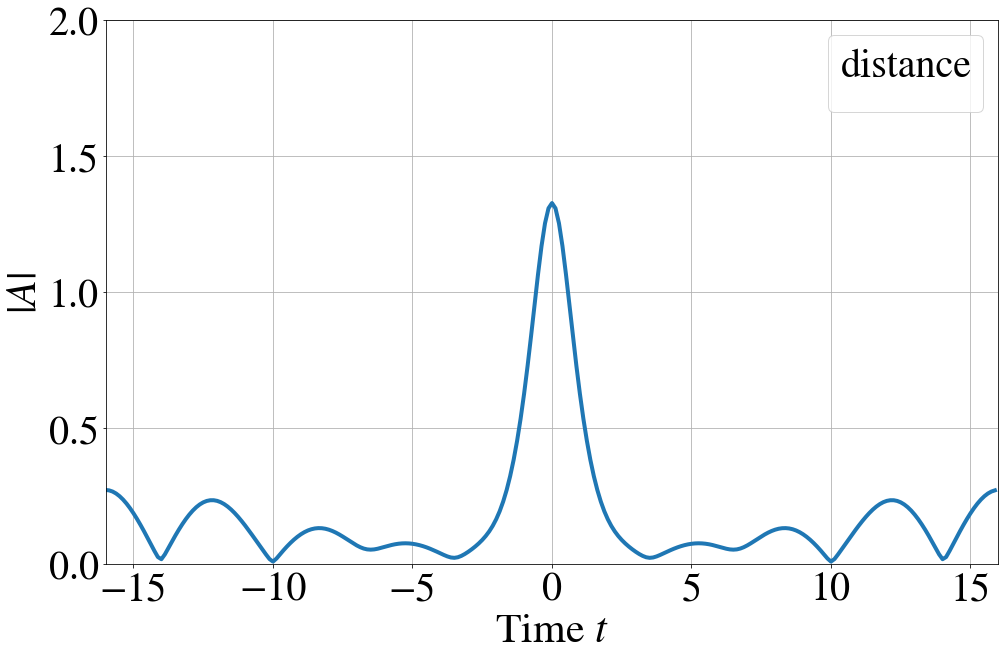

In [64]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(16,10))
ax_anim = plt.axes(xlim=(-t_span / 2, t_span / 2), ylim=(0, 2))
# ax_anim = fig.add_subplot(111)
line, = ax_anim.plot([], [], lw=4)

# initialization function
def init():
	# creating an empty plot/frame
	line.set_data([], [])
	return line,


# animation function
def animate(i):
    # t is a parameter
    z_prop = i % 20 + 1

    # x, y values to be plotted
    y = df_p1_ref[df_p1_ref.z_prop == z_prop].signal_end.item()

    # appending new points to x, y axes points list
    # ax_anim.plot(t, np.absolute(y),
    #         label='z = ' + str(z_prop),
    #         linewidth=4.0)


    
    line.set_data(t, np.absolute(y))
    # ax_anim.set_label(str(z_prop))
    line.set_label(str(z_prop))
    return line,

ax_anim.legend(title='distance', loc='best', fontsize=30)
ax_anim.set_ylabel(r'$|A|$', fontsize=42)
ax_anim.set_xlabel(r'Time $t$', fontsize=42)
ax_anim.grid()

# call the animator
anim = animation.FuncAnimation(fig, animate, frames=20, interval=1, init_func=init, blit=True)

# save the animation as mp4 video file
anim.save(r'../wf_opt_results/' + 'bl_' + str(cur_band_limit) + '_e_' + str(cur_energy) + '.gif', writer='imagemagick')

In [21]:
a = 1.
test_s = get_gauss_pulse(a, t, tau=1)
print(sg.get_energy(test_s, dt))

14.17963080724413


In [ ]:
# data.append({'energy_sys': 3.0})
print(data['x'])